In [1]:
# import libraries

import earthaccess
import xarray as xr
import dask
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio import features
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj, Transformer

# colormap for plotting sea ice throughout rest of project

cmap = plt.get_cmap("Blues").copy()
cmap.set_bad(color='lightgray')

# authenticate NASA earth access

auth = earthaccess.login(strategy='interactive', persist = True)

In [2]:
# search NASA database

results = earthaccess.search_data(
    short_name='NSIDC-0079',
    temporal=('2023-04-01', '2023-05-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

print(f"here we found {len(results)} results")

here we found 63 results


In [3]:
# stream files into xarray

files = earthaccess.open(results)
ds = xr.open_mfdataset(files, parallel=True, combine='by_coords')

QUEUEING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/63 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/63 [00:00<?, ?it/s]

In [4]:
# check files

files

[<File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0079/4/2023/04/01/NSIDC0079_SEAICE_PS_N25km_202304_v4.0.nc>,
 <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0079/4/2023/04/01/NSIDC0079_SEAICE_PS_N25km_20230401_v4.0.nc>,
 <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0079/4/2023/04/02/NSIDC0079_SEAICE_PS_N25km_20230402_v4.0.nc>,
 <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0079/4/2023/04/03/NSIDC0079_SEAICE_PS_N25km_20230403_v4.0.nc>,
 <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0079/4/2023/04/04/NSIDC0079_SEAICE_PS_N25km_20230404_v4.0.nc>,
 <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/

In [5]:
ds = xr.open_mfdataset(files, chunks={'time': 10})

In [6]:
# read in land file from geopandas

land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
land = land.to_crs(epsg=3411)

# create affine transform and make sure arctic is not upside down

dx = float(ds.x.diff('x').mean())
dy = float(ds.y.diff('y').mean())
x0 = float(ds.x.min())
y0 = float(ds.y.max())

transform = [dx, 0, x0, 0, -abs(dy), y0]

# use transform to mask out coastal cells

land_mask = features.rasterize(
    ((geom, 1) for geom in land.geometry),
    out_shape=(ds.sizes['y'], ds.sizes['x']),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# calculate distance from land using euclidian distance transform

distance_from_land = distance_transform_edt(land_mask == 0)

# convert to xarray.DataArray

distance_xr = xr.DataArray(
    distance_from_land,
    coords={'y': ds.y, 'x': ds.x},
    dims=('y', 'x'),
    name='distance_to_land_cells'
)

# add as data variable in ds

ds['edtl'] = distance_xr

In [7]:
# read in visual data and do some conversions

visual = pd.read_csv("../local_data/big_array_coast_cell_smallest.csv")
visual["time"] = pd.to_datetime(visual["Date"], yearfirst = True)
visual.head(10)

,system:index,Cloud cover,Column,Date,Land frac,Ocean frac,Row,SI frac,Scene ID,Snow frac,Sun azimuth,Sun elevation,WRS path,WRS row,total pixels,.geo,time
0,00000000000000000000,0.0,256.0,2023-04-19,0.004014,0.0,47.0,0.0,LC90530142023109LGN00,0.995986,169.913151,35.396205,53.0,14.0,671698,"{""type"":""Polygon"",""coordinates"":[[[-123.381475...",2023-04-19
1,00000000000000000001,0.0,257.0,2023-04-19,0.000000,0.0,47.0,0.0,LC90530142023109LGN00,1.000000,169.913151,35.396205,53.0,14.0,671167,"{""type"":""Polygon"",""coordinates"":[[[-122.868679...",2023-04-19
2,00000000000000000002,0.0,259.0,2023-04-19,0.027171,0.0,47.0,0.0,LC90530142023109LGN00,0.972829,169.913151,35.396205,53.0,14.0,670779,"{""type"":""Polygon"",""coordinates"":[[[-121.849051...",2023-04-19
3,00000000000000000003,0.0,256.0,2023-04-19,0.002093,0.0,48.0,0.0,LC90530142023109LGN00,0.997907,169.913151,35.396205,53.0,14.0,672582,"{""type"":""Polygon"",""coordinates"":[[[-123.274888...",2023-04-19
4,00000000000000000004,0.0,257.0,2023-04-19,0.000000,0.0,48.0,0.0,LC90530142023109LGN00,1.000000,169.913151,35.396205,53.0,14.0,672346,"{""type"":""Polygon"",""coordinates"":[[[-122.757668...",2023-04-19
5,00000000000000000005,0.0,259.0,2023-04-19,0.072040,0.0,48.0,0.0,LC90530142023109LGN00,0.927960,169.913151,35.396205,53.0,14.0,671862,"{""type"":""Polygon"",""coordinates"":[[[-121.729356...",2023-04-19
6,00000000000000000006,0.0,260.0,2023-04-19,0.024412,0.0,48.0,0.0,LC90530142023109LGN00,0.975588,169.913151,35.396205,53.0,14.0,671675,"{""type"":""Polygon"",""coordinates"":[[[-121.218402...",2023-04-19
7,00000000000000000007,0.0,261.0,2023-04-19,0.006646,0.0,48.0,0.0,LC90530142023109LGN00,0.993354,169.913151,35.396205,53.0,14.0,646279,"{""type"":""Polygon"",""coordinates"":[[[-120.709674...",2023-04-19
8,00000000000000000008,0.0,262.0,2023-03-13,0.231928,0.0,48.0,0.0,LC90500152023072LGN00,0.768072,167.020963,22.380426,50.0,15.0,392932,"{""type"":""Polygon"",""coordinates"":[[[-119.842207...",2023-03-13
9,00000000000000000009,0.0,252.0,2023-04-26,0.011049,0.0,49.0,0.0,LC90540142023116LGN00,0.988951,170.070773,37.748011,54.0,14.0,674888,"{""type"":""Polygon"",""coordinates"":[[[-125.272421...",2023-04-26


In [8]:
# convert rows and columns into lats and lons

row_to_lat = dict(enumerate(ds['x'].values))
col_to_lon = dict(enumerate(ds['y'].values))
visual['x'] = visual['Row'].map(row_to_lat)
visual['y'] = visual['Column'].map(col_to_lon)

# convert pandas dataframe of visual things into chunked xarray dataset on time, lat, and long

da_sparse = visual.set_index(['time', 'y', 'x']).to_xarray()
da_full = da_sparse.reindex_like(ds, method=None)
da_full = da_full.chunk({'time': 2})
da_full

# assign visual data to the NASA team dataset and sanity check plot

ds = ds.assign(**{'visual_ice': da_full['SI frac']})

In [10]:
# data cleaning (1.100 = coast, 1.200 = land)

condition = ((ds.visual_ice.notnull()) & (ds.F17_ICECON < 1.01))
ds_clean = ds.where(condition, other=np.nan).compute()

df = ds_clean.to_dataframe().reset_index().dropna()
df.head(10)

,time,y,x,F17_ICECON,crs,edtl,visual_ice
86426,2023-04-01,-1262500.0,-1587500.0,1.000,b'',1.0,0.966116
86728,2023-04-01,-1287500.0,-1637500.0,0.944,b'',0.0,0.828158
87031,2023-04-01,-1312500.0,-1662500.0,0.967,b'',0.0,0.996476
87934,2023-04-01,-1387500.0,-1887500.0,0.949,b'',1.0,0.999314
88235,2023-04-01,-1412500.0,-1962500.0,0.941,b'',1.0,0.981114
88238,2023-04-01,-1412500.0,-1887500.0,0.943,b'',0.0,0.714247
88847,2023-04-01,-1462500.0,-1862500.0,0.925,b'',1.0,0.725841
88850,2023-04-01,-1462500.0,-1787500.0,0.946,b'',1.0,0.236230
89151,2023-04-01,-1487500.0,-1862500.0,0.930,b'',0.0,0.484039
89152,2023-04-01,-1487500.0,-1837500.0,0.926,b'',1.0,0.948664


In [32]:
# convert dataset to lat / lon from meters

ps_north = Proj('EPSG:3411')  
wgs84 = Proj('EPSG:4326')
transformer = Transformer.from_proj(ps_north, wgs84)

# convert grid coordinates

x = ds.x.values
y = ds.y.values
lon, lat = transformer.transform(*np.meshgrid(x, y))

# assign lat / lon to dataset and print

ds = ds.assign_coords(lon=(('y', 'x'), lon),
                      lat=(('y', 'x'), lat))

ds

<xarray.Dataset> Size: 136MB
Dimensions:     (time: 61, y: 448, x: 304)
Coordinates:
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time        (time) datetime64[ns] 488B 2023-04-01 2023-04-02 ... 2023-05-31
    lon         (y, x) float64 1MB 31.1 31.2 31.3 31.39 ... 34.68 34.58 34.47
    lat         (y, x) float64 1MB 168.3 168.1 168.0 ... -10.36 -10.18 -9.999
Data variables:
    crs         (time) |S1 61B b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    F17_ICECON  (time, y, x) float64 66MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    edtl        (y, x) float64 1MB 106.5 105.6 104.7 103.8 ... 15.3 15.52 15.81
    visual_ice  (time, y, x) float64 66MB dask.array<chunksize=(2, 448, 304), meta=np.ndarray>
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

<Figure size 640x480 with 0 Axes>

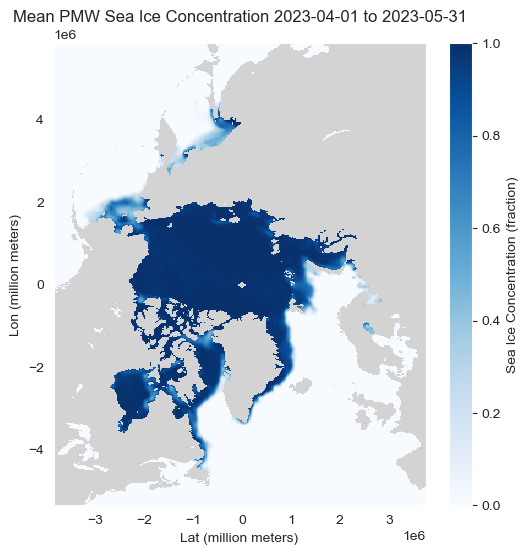

In [11]:
# sanity check one

sns.set_style('darkgrid')
sns.despine()

ds_subset = ds.where(ds.F17_ICECON < 1.01)
ax = ds_subset.F17_ICECON.mean(dim='time').plot(
    cmap=cmap,
    cbar_kwargs={'label': 'Sea Ice Concentration (fraction)'},
    figsize=(6,6)
)

plt.title("Mean PMW Sea Ice Concentration 2023-04-01 to 2023-05-31")
plt.xlabel("Lat (million meters)")
plt.ylabel("Lon (million meters)")
plt.show()

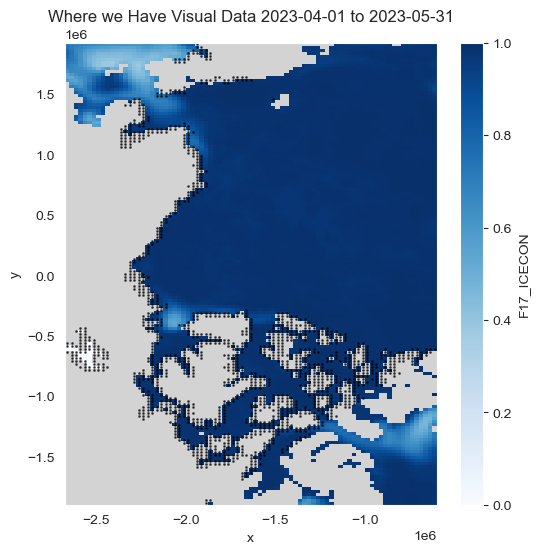

In [12]:
# sanity check two

x_min, x_max = visual['x'].min(), visual['x'].max()
y_min, y_max = visual['y'].min(), visual['y'].max()

ds_subset = ds.sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).where(ds.F17_ICECON < 1.01)
ax = ds_subset.F17_ICECON.mean(dim='time').plot(
    cmap=cmap,
    figsize=(6,6)
)

plt.scatter(
    visual['x'],
    visual['y'],
    color='black',
    s=1,
    alpha=0.6
)
plt.title("Where we Have Visual Data 2023-04-01 to 2023-05-31")
plt.show()

In [15]:
# error calculation

rmse = ((((ds_clean['F17_ICECON'] - ds_clean['visual_ice']))**2)**0.5)
rmse_avg = rmse.mean(dim=['time', 'x', 'y'], skipna=True)
print('RMS error is', rmse_avg.compute().item())

RMS error is 0.299682717919702


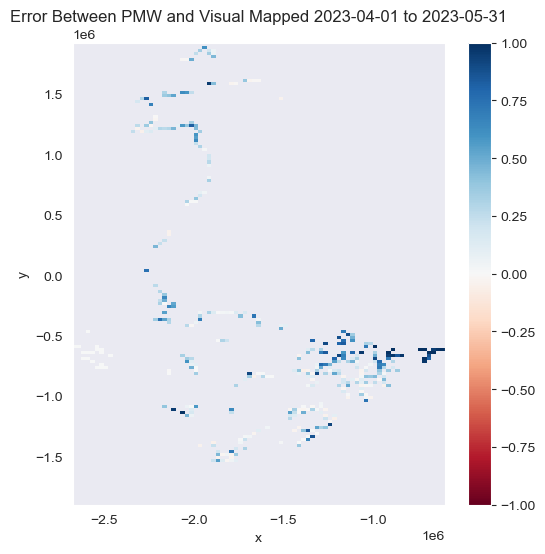

In [16]:
# calculate signed error

error = ((ds_clean['F17_ICECON'] - ds_clean['visual_ice']))

# error colors

sns.set_style('darkgrid')

# map error

error_subset = error.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))
ax = error_subset.mean(dim='time', skipna=True).plot(cmap = 'RdBu', figsize=(6,6))
plt.title("Error Between PMW and Visual Mapped 2023-04-01 to 2023-05-31")
plt.show()